In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import os

In [2]:
file_path1 = 'Tropics_tp&cape_5*5.nc'
file_path2 = 'Tropics_cin_5*5.nc'
  
#Opening dataset for tropics                                   
dsT1 = xr.open_dataset(file_path1)
dsT2 = xr.open_dataset(file_path2)

In [3]:
merged_ds = xr.merge([dsT1, dsT2])

In [4]:
daily_meanT = merged_ds.resample(time='D').mean(dim='time')

avg_dsMT = merged_ds.mean(dim=['latitude', 'longitude'])  

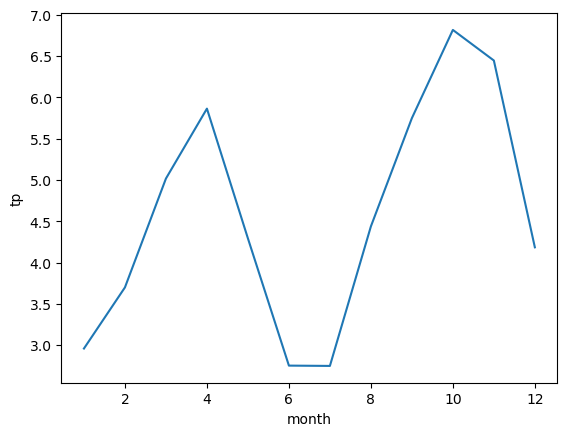

In [5]:
tp_mmpd = merged_ds['tp']*1e3*24
tp_spatial = tp_mmpd.mean(dim = ['latitude','longitude'])
tp_seasonal = tp_spatial.groupby('time.month').mean()
tp_seasonal.plot()



In [6]:

winter_data = avg_dsMT.sel(time=avg_dsMT['time.season']=='DJF')
spring_data = avg_dsMT.sel(time=avg_dsMT['time.season']=='MAM')
summer_data = avg_dsMT.sel(time=avg_dsMT['time.season']=='JJA')
fall_data = avg_dsMT.sel(time=avg_dsMT['time.season']=='SON')

In [7]:
cape_bins = np.linspace(0, 2500, 17)
cins = []
tps = []
for data in (summer_data, winter_data, fall_data, spring_data):
    positive_precip = data['tp'].where((data['tp']*24000) > 1.0)
    cape_positive_precip = data['cape'].where((data['tp']*24000) > 1.0)
    binned_precipitation = positive_precip.groupby_bins(cape_positive_precip, bins=cape_bins)
    binned_cin = data['cin'].groupby_bins(cape_positive_precip, bins=cape_bins)
    avgcin = binned_cin.mean()
    avgtp = binned_precipitation.mean()
    cape_mid = (cape_bins[1:] + cape_bins[:-1])/2
    cins.append(avgcin)
    tps.append(avgtp)

In [8]:
cins

[<xarray.DataArray 'cin' (cape_bins: 16)>
 array([226.80347, 219.6795 , 213.97987, 203.60309, 190.58466, 173.07072,
        156.26587, 153.26465, 146.28601, 145.12149, 156.67912, 157.38618,
        176.52756, 179.93204, 189.32971, 205.64397], dtype=float32)
 Coordinates:
   * cape_bins  (cape_bins) object (0.0, 156.25] ... (2343.75, 2500.0],
 <xarray.DataArray 'cin' (cape_bins: 16)>
 array([278.33948, 261.0509 , 251.40523, 240.55443, 224.02069, 220.12132,
        218.04416, 199.30174, 186.39815, 181.79259, 186.09024, 192.44087,
        200.72981, 222.7628 , 211.51689, 240.65703], dtype=float32)
 Coordinates:
   * cape_bins  (cape_bins) object (0.0, 156.25] ... (2343.75, 2500.0],
 <xarray.DataArray 'cin' (cape_bins: 16)>
 array([201.31836, 196.7021 , 170.5188 , 160.52174, 162.34042, 159.95833,
        152.1964 , 142.3287 , 130.9425 , 125.89254, 125.7386 , 135.11221,
        155.14693, 164.43852, 171.66699, 187.83867], dtype=float32)
 Coordinates:
   * cape_bins  (cape_bins) object (0.0,

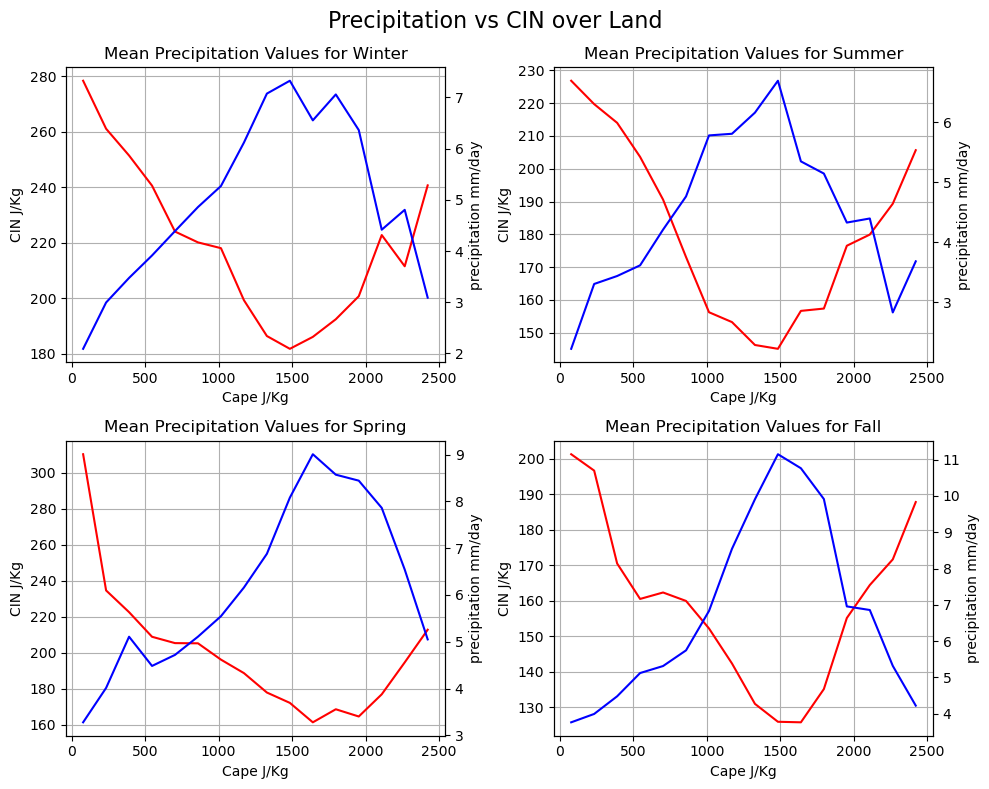

In [9]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, j, season, avgcin, avgtp in ((0, 0, "Winter", cins[1], tps[1]), (0, 1, "Summer", cins[0], tps[0]), (1, 0, "Spring", cins[3], tps[3]), (1, 1, "Fall", cins[2], tps[2])):

    axs[i, j].plot(cape_mid, avgcin, color='r', label=f'{season}')
    axs[i, j].set_xlabel('Cape J/Kg')
    axs[i, j].set_ylabel('CIN J/Kg')
    axs[i, j].set_title(f'Mean Precipitation Values for {season}')
    axs[i, j].grid(True)
    ax2 = axs[i, j].twinx()  # Use axs[0, 0] instead of undefined ax1
    ax2.plot(cape_mid, avgtp*24000, 'b-', label='cape')
    ax2.set_ylabel('precipitation mm/day')
    ax2.tick_params(axis='y')

plt.suptitle("Precipitation vs CIN over Land", fontsize=16)
plt.tight_layout()
plt.show()